# Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Delay Data Loading

In [5]:
df = pd.read_excel ('https://full-stack-assets.s3.eu-west-3.amazonaws.com/Deployment/get_around_delay_analysis.xlsx')

print(df.shape)
df.head(10)
df.info()
df.describe()

(21310, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21310 entries, 0 to 21309
Data columns (total 7 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rental_id                                   21310 non-null  int64  
 1   car_id                                      21310 non-null  int64  
 2   checkin_type                                21310 non-null  object 
 3   state                                       21310 non-null  object 
 4   delay_at_checkout_in_minutes                16346 non-null  float64
 5   previous_ended_rental_id                    1841 non-null   float64
 6   time_delta_with_previous_rental_in_minutes  1841 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.1+ MB


,rental_id,car_id,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
count,21310.000000,21310.000000,16346.000000,1841.000000,1841.000000
mean,549712.880338,350030.603426,59.701517,550127.411733,279.288430
std,13863.446964,58206.249765,1002.561635,13184.023111,254.594486
min,504806.000000,159250.000000,-22433.000000,505628.000000,0.000000
25%,540613.250000,317639.000000,-36.000000,540896.000000,60.000000
50%,550350.000000,368717.000000,9.000000,550567.000000,180.000000
75%,560468.500000,394928.000000,67.000000,560823.000000,540.000000
max,576401.000000,417675.000000,71084.000000,575053.000000,720.000000


# Basics statistics

In [7]:
print("=== Missing values ===")
print(df.isnull().sum())

print("\n=== Checkin type  ===")
print(df['checkin_type'].value_counts())

print("\n=== location_state ===")
print(df['state'].value_counts())

print("\n=== Delay Stats  ===")
print(df['delay_at_checkout_in_minutes'].describe())

=== Missing values ===
rental_id                                         0
car_id                                            0
checkin_type                                      0
state                                             0
delay_at_checkout_in_minutes                   4964
previous_ended_rental_id                      19469
time_delta_with_previous_rental_in_minutes    19469
dtype: int64

=== Checkin type  ===
checkin_type
mobile     17003
connect     4307
Name: count, dtype: int64

=== location_state ===
state
ended       18045
canceled     3265
Name: count, dtype: int64

=== Delay Stats  ===
count    16346.000000
mean        59.701517
std       1002.561635
min     -22433.000000
25%        -36.000000
50%          9.000000
75%         67.000000
max      71084.000000
Name: delay_at_checkout_in_minutes, dtype: float64


Total rentals with known checkout: 16346
Late returns: 9404 (57.5%)
On time or early: 6942 (42.5%)


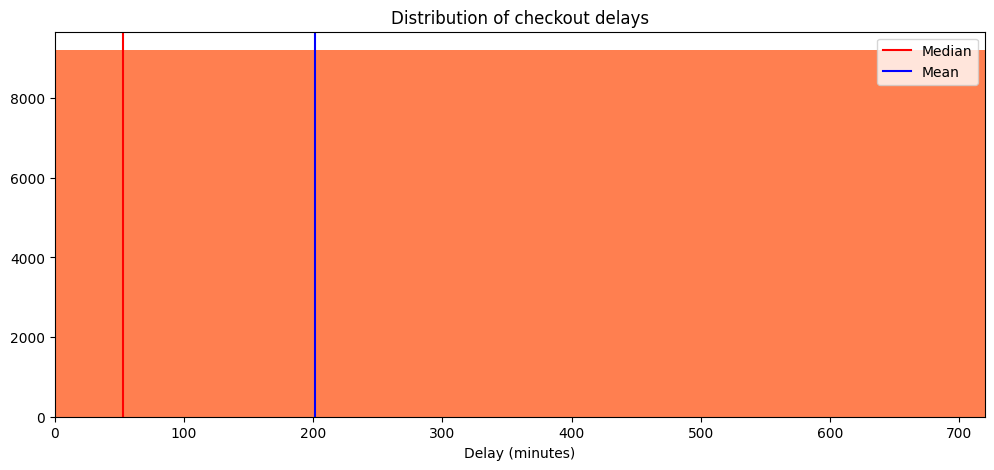

In [8]:
# Separate late returns from on-time returns
late = df[df['delay_at_checkout_in_minutes'] > 0]
on_time = df[df['delay_at_checkout_in_minutes'] <= 0]

print(f"Total rentals with known checkout: {df['delay_at_checkout_in_minutes'].notna().sum()}")
print(f"Late returns: {len(late)} ({len(late)/df['delay_at_checkout_in_minutes'].notna().sum()*100:.1f}%)")
print(f"On time or early: {len(on_time)} ({len(on_time)/df['delay_at_checkout_in_minutes'].notna().sum()*100:.1f}%)")

# Delay distribution
plt.figure(figsize=(12,5))
plt.hist(late['delay_at_checkout_in_minutes'], bins=50, color='coral')
plt.axvline(late['delay_at_checkout_in_minutes'].median(), color='red', label='Median')
plt.axvline(late['delay_at_checkout_in_minutes'].mean(), color='blue', label='Mean')
plt.xlabel('Delay (minutes)')
plt.title('Distribution of checkout delays')
plt.legend()
plt.xlim(0, 720)  # capped at 12h for readability
plt.show()

# Analysis of the impact on the next rental

In [13]:
# Problematic cases = previous rental late + next rental exists
# We merge the dataframe onto itself to find pairs
df_with_previous = df[df['previous_ended_rental_id'].notna()].copy()

# Retrieve information from the previous rental
df_previous = df[['rental_id', 'delay_at_checkout_in_minutes']].rename(
    columns={
        'rental_id': 'previous_ended_rental_id',
        'delay_at_checkout_in_minutes': 'previous_delay'
    })


df_merged = df_with_previous.merge(df_previous, on='previous_ended_rental_id', how='left')

print(f"Rentals with a previous rental: {len(df_merged)}")

# Cases where the delay from the previous rental exceeds the available time
df_merged['impacted'] = (
    df_merged['previous_delay'] > df_merged['time_delta_with_previous_rental_in_minutes']
)

print(f"Rentals impacted by a delay: {df_merged['impacted'].sum()}")
print(f"That is: {df_merged['impacted'].mean()*100:.1f}%")

Rentals with a previous rental: 1841
Rentals impacted by a delay: 218
That is: 11.8%


#  Threshold simulation

In [14]:
# How many ADDITIONAL rentals would be blocked according to the threshold?
thresholds = [0, 15, 30, 60, 120, 180, 240, 360, 480, 720]

results = []
for t in thresholds:
    # Rentals where the time between rentals is less than the threshold
    blocked = df[df['time_delta_with_previous_rental_in_minutes'] < t]
    
    # Among the problematic cases, how many would be resolved?
    if len(df_merged) > 0:
        solved = df_merged[
            (df_merged['impacted'] == True) & 
            (df_merged['time_delta_with_previous_rental_in_minutes'] < t)
        ]
    
    results.append({
        'threshold': t,
        'blocked_rentals': len(blocked),
        'pct_blocked': len(blocked)/len(df)*100,
        'problems_solved': len(solved) if len(df_merged) > 0 else 0
    })

df_results = pd.DataFrame(results)
print(df_results)

   threshold  blocked_rentals  pct_blocked  problems_solved
0          0                0     0.000000                0
1         15              279     1.309244              116
2         30              279     1.309244              116
3         60              401     1.881746              146
4        120              666     3.125293              180
5        180              870     4.082590              196
6        240             1001     4.697325              202
7        360             1170     5.490380              208
8        480             1290     6.053496              211
9        720             1711     8.029094              216


# Connect vs. Mobile Analysis

In [17]:
for checkin_type in ['connect', 'mobile']:
    subset = df[df['checkin_type'] == checkin_type]
    late_subset = subset[subset['delay_at_checkout_in_minutes'] > 0]
    print(f"\n--- {checkin_type.upper()} ---")
    print(f"Total: {len(subset)}")
    print(f"Late: {len(late_subset)} ({len(late_subset)/len(subset)*100:.1f}%)")
    print(f"Median delay: {late_subset['delay_at_checkout_in_minutes'].median():.0f} min")


--- CONNECT ---
Total: 4307
Late: 1459 (33.9%)
Median delay: 41 min

--- MOBILE ---
Total: 17003
Late: 7945 (46.7%)
Median delay: 56 min
